In [85]:
import os
import keras
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import  Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import EarlyStopping, LearningRateScheduler
from random import shuffle
import math
from keras import layers
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras.models import load_model

In [3]:
PathSpectogramFolder='Spectogram'
OutputPath='model/4/path'
OutputPathModels='model/4/'
interictalSpectograms=[]
preictalSpectograms=[]  #This array contains syntetic data, it's created to have a balance dataset and it's used for training
preictalRealSpectograms=[]  #This array containt the real preictal data, it's used for testing
patients = ["01","02","03","05","09","10","13","18","19","21","23"]
#patients = ["01","02","03","05","09"]
nSeizure=0

In [4]:
def loadSpectogramData(indexPat):
    global interictalSpectograms
    global preictalSpectograms
    global preictalRealSpectograms
    global nSeizure
    f = open(PathSpectogramFolder+'/paz'+patients[indexPat]+'/legendAllData.txt', 'r')
    line=f.readline()
    while(not "SEIZURE" in line):
        line=f.readline()
    nSeizure=int(line.split(":")[1].strip())
    line=f.readline()
    line=f.readline()#legge il numero di spectogrammi. non lo salvo dato che non mi serve
    nSpectograms=int(line.strip())
    nFileForSeizure=math.ceil(math.ceil(nSpectograms/50)/nSeizure)
    line=f.readline()#leggo il percorso del primo file
    
    #Lettura path files Interictal
    cont=-1
    indFilePathRead=0
    while("npy" in line and indFilePathRead<nSeizure*nFileForSeizure):
        if(indFilePathRead%nFileForSeizure==0):
            interictalSpectograms.append([])
            cont=cont+1
            interictalSpectograms[cont].append(line.split(' ')[2].rstrip())#.rstrip() remove \n
            indFilePathRead=indFilePathRead+1
        else:
            if(len(line.split(' '))>=3):
                interictalSpectograms[cont].append(line.split(' ')[2].rstrip())
            indFilePathRead=indFilePathRead+1
            
        line=f.readline()
    line=f.readline()#leggo PREICTAL
    line=f.readline()#leggo n° spectogram
    line=f.readline()#leggo n°seizure(SEIZURE X)

    #Lettura path files Preictal
    cont=-1
    indFilePathRead=0   
    #while(line and indFilePathRead<nSeizure*nFileForSeizure):    
    while(line.strip()!=""):
        if("SEIZURE" in line):
            line=f.readline()#ho letto n°seizure(SEIZURE X) perciò scorro in avanti
            if(len(line.split(' '))>=3):
                preictalSpectograms.append([])
                cont=cont+1
                preictalSpectograms[cont].append(line.split(' ')[2].rstrip())
                indFilePathRead=indFilePathRead+1
        else:
            if(len(line.split(' '))>=3):
                preictalSpectograms[cont].append(line.split(' ')[2].rstrip())
            indFilePathRead=indFilePathRead+1
            
        line=f.readline()
        
    line=f.readline()#leggo REAL_PREICTAL
    line=f.readline()#leggo n° spectogram
    line=f.readline()#leggo n°seizure(SEIZURE X)

    #Lettura path files Real Preictal
    cont=-1
    while(line):
        if("SEIZURE" in line):
            line=f.readline()#ho letto n°seizure(SEIZURE X) perciò scorro in avanti
            preictalRealSpectograms.append([])
            cont=cont+1
            preictalRealSpectograms[cont].append(line.split(' ')[2].rstrip())
        else:
            preictalRealSpectograms[cont].append(line.split(' ')[2].rstrip())
            
        line=f.readline()
    f.close()

In [108]:
def createModel():

    model = Sequential()

    # C1
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(22, 59, 114)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # C2
    model.add(Conv2D(32, (2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # C3
    model.add(Conv2D(64, (2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    return model

In [83]:
def createModel2():

    model = Sequential()

    # C1
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(22, 59, 114)))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    # C2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # C3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(layers.GRU(256, input_shape=(None, 384)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(layers.GRU(100, input_shape=(None, 384)))
    model.add(Dense(2, activation='softmax'))


    return model

In [72]:
def createModel1():

    model = Sequential()

    model.add(Conv2D(64, (2, 4), activation='relu', input_shape=(22, 59, 114)))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1, 2)))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.15))
    model.add(Dense(2, activation='softmax'))

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Recall(name='sen')])
        
    return model

In [7]:
def getFilesPathWithoutSeizure(indexSeizure):
    filesPath=[]
    for i in range(0, nSeizure):
        if(i!=indexSeizure):
            filesPath.extend(interictalSpectograms[i])
            filesPath.extend(preictalSpectograms[i])
    shuffle(filesPath)
    return filesPath

In [8]:
def generate_arrays_for_training(paths, start=0, end=100):
    while True:
        from_=int(len(paths)/100*start)
        to_=int(len(paths)/100*end)
        for i in range(from_, int(to_)):
            f=paths[i]
            x = np.load(PathSpectogramFolder+f)
            x=np.array([x])
            x=x.swapaxes(0,1)
            x=x[0]
            if('P' in f):
                y = np.repeat([[0,1]], x.shape[0], axis=0)
            else:
                y = np.repeat([[1,0]], x.shape[0], axis=0)
            yield(x,y)

In [9]:
def generate_arrays_for_predict(indexPat, paths, start=0, end=100):
    while True:
        f = open(PathSpectogramFolder+'/paz'+patients[indexPat]+'/legendAllData.txt', 'r')
        line=f.readline()
        while(not "SEIZURE" in line):
            line=f.readline()
        nSeizure=int(line.split(":")[1].strip())
        from_=int(len(paths)/100*start)
        to_=int(len(paths)/100*end)
        for i in range(from_, int(to_)):
            f=paths[i]
            x = np.load(PathSpectogramFolder+f)
            x=np.array([x])
            x=x.swapaxes(0,1)
            x=x[0]
            yield(x)

START
Parameters loaded
Patient 01
Patient 02
Patient 03
Patient 05
Patient 09
(1240,)
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_183 (Conv2D)         (None, 21, 56, 64)        58432     
                                                                 
 batch_normalization_183 (Ba  (None, 21, 56, 64)       256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_183 (MaxPooli  (None, 21, 28, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_243 (Dropout)       (None, 21, 28, 64)        0         
                                                                 
 conv2d_184 (Conv2D)         (None, 20, 27, 32)        8224      
                                

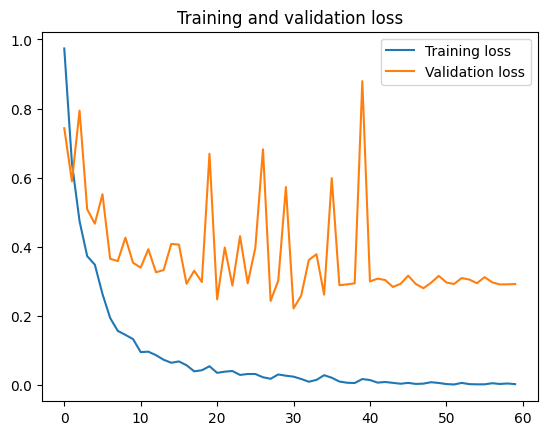

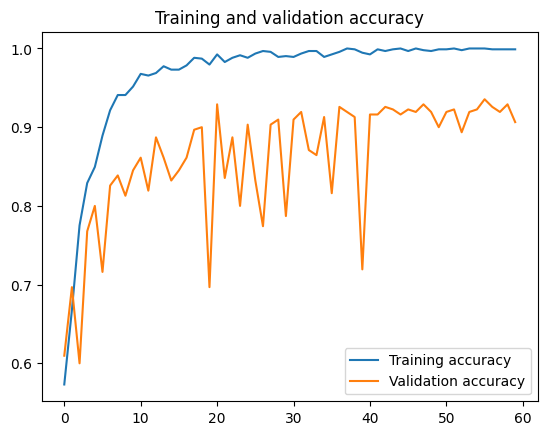

Training end


In [72]:
print("START")
if not os.path.exists(OutputPathModels):
    os.makedirs(OutputPathModels)
print("Parameters loaded")
nSeizure=0

for indexPat in range(0, len(patients)):
    print('Patient '+patients[indexPat])
    loadSpectogramData(indexPat) 
       
result='Out Seizure, True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR \n'
filesPath = getFilesPathWithoutSeizure(i)
print(np.shape(filesPath))
    
initial_learning_rate = 0.001
decay_steps = 1000  # Numero di passi di addestramento dopo i quali applicare il decay
decay_rate = 0.1  # Tasso di decay
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

model = createModel()
model.summary()

history = model.fit(generate_arrays_for_training(filesPath, end=75), #end=75),#It take the first 75%
                        validation_data=generate_arrays_for_training(filesPath, start=75),#start=75), #It take the last 25%
                        #steps_per_epoch=10000, epochs=10)
                        steps_per_epoch=int((len(filesPath)-int(len(filesPath)/100*25))),#*25), 
                        validation_steps=int((len(filesPath)-int(len(filesPath)/100*75))),#*75),
                        epochs=60, max_queue_size=2, shuffle=True, callbacks=[LearningRateScheduler(lr_schedule)])# 100 epochs è meglio #aggiungere criterio di stop in base accuratezza

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Creates a HDF5 file 
model.save(OutputPathModels+"ModelPat"+patients[indexPat]+"/"+'ModelOutSeizure'+str(i+1)+'.h5')
print("Model saved")
        
epochs = range(len(train_loss))

plt.figure()
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

print('Training end')


In [32]:
for indexPat in range(0, len(patients)):
    print('Patient '+patients[indexPat])
    loadSpectogramData(indexPat)

Patient 01
Patient 02
Patient 03
Patient 05
Patient 09


START
Parameters loaded
Patient 01
Patient 02
Patient 03
Patient 05
Patient 09
(4960,)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 21, 56, 64)        58432     
                                                                 
 batch_normalization_19 (Bat  (None, 21, 56, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 21, 28, 64)       0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 21, 28, 64)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 20, 27, 32)        8224      
                                 

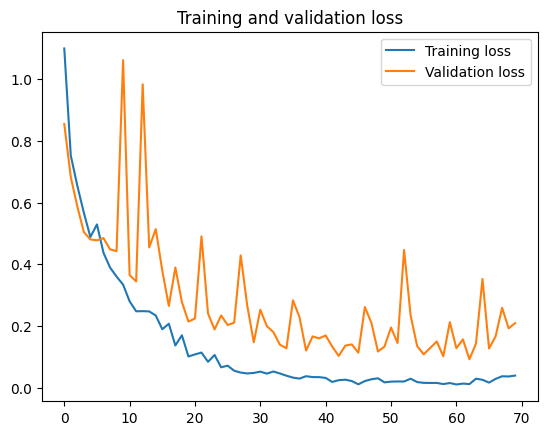

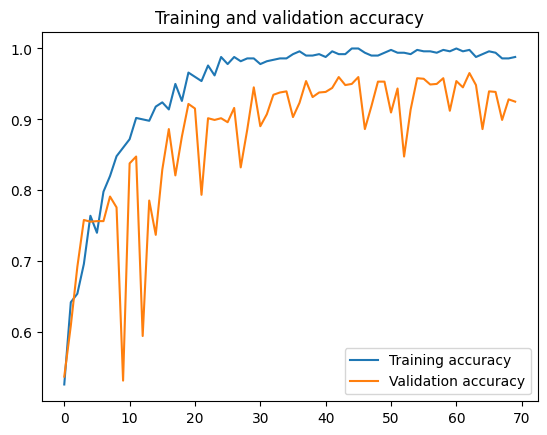

Training end


In [41]:
print("START")
print("Parameters loaded")
nSeizure=0

for indexPat in range(0, len(patients)):
    print('Patient '+patients[indexPat])
    loadSpectogramData(indexPat) 
       
result='Out Seizure, True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR \n'
filesPath = getFilesPathWithoutSeizure(i)
print(np.shape(filesPath))
    
initial_learning_rate = 0.001
decay_steps = 1000  # Numero di passi di addestramento dopo i quali applicare il decay
decay_rate = 0.1  # Tasso di decay
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

model = createModel()
model.summary()

history = model.fit(generate_arrays_for_training(filesPath, end=75), #end=75),#It take the first 75%
                        validation_data=generate_arrays_for_training(filesPath, start=75),#start=75), #It take the last 25%
                        steps_per_epoch=500,
                        #steps_per_epoch=int((len(filesPath)-int(len(filesPath)/100*25))),#*25), 
                        validation_steps=int((len(filesPath)-int(len(filesPath)/100*75))),#*75),
                        epochs=70, max_queue_size=3, shuffle=True, callbacks=[LearningRateScheduler(lr_schedule)])# 100 epochs è meglio #aggiungere criterio di stop in base accuratezza

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Creates a HDF5 file 
model.save(OutputPathModels+"ModelPat"+patients[indexPat]+"/"+'ModelOutSeizure'+str(i+1)+'.h5')
print("Model saved")
        
epochs = range(len(train_loss))

plt.figure()
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

print('Training end')

START
Parameters loaded
Patient 01
Patient 02
Patient 03
Patient 05
Patient 09
Patient 10
Patient 23
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_178 (Conv2D)         (None, 22, 59, 16)        16432     
                                                                 
 batch_normalization_42 (Bat  (None, 22, 59, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_167 (MaxPooli  (None, 11, 29, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_179 (Conv2D)         (None, 11, 29, 32)        2080      
                                                                 
 batch_normalization_43 (Bat  (None, 11, 29, 32)       128       
 chNormalization) 

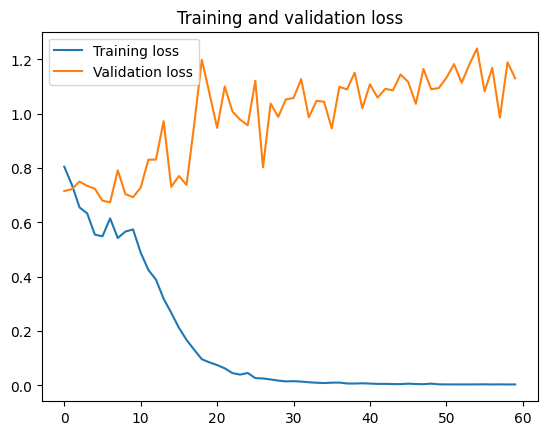

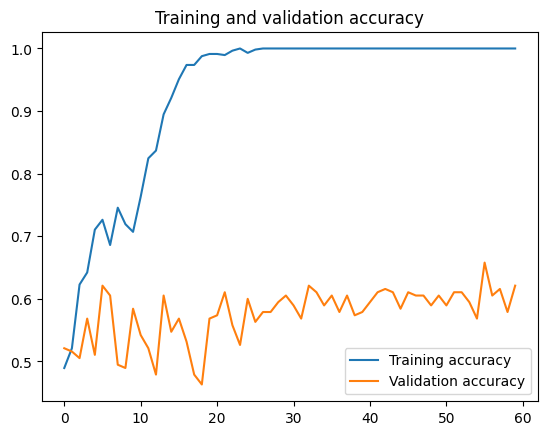

Training end


In [109]:
print("START")
if not os.path.exists(OutputPathModels):
    os.makedirs(OutputPathModels)
print("Parameters loaded")

nSeizure=0
interictalSpectograms=[]
preictalSpectograms=[]  #This array contains syntetic data, it's created to have a balance dataset and it's used for training
preictalRealSpectograms=[]  #This array containt the real preictal data, it's used for testing
#patients = ["01","02","03","05","09"]
patients = ["01","02","03","05","09","10","23"]

for indexPat in range(0, len(patients)):
    print('Patient '+patients[indexPat])
    loadSpectogramData(indexPat) 
    filesPath = getFilesPathWithoutSeizure(indexPat)
       
result='Out Seizure, True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR \n'

model = createModel()
model.summary()

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Recall(name='sen')])
    
history = model.fit(generate_arrays_for_training(filesPath, end=80), #end=75),#It take the first 75%
                        validation_data=generate_arrays_for_training(filesPath, start=80),#start=75), #It take the last 25%
                        #steps_per_epoch=350, validation_steps=100,
                        steps_per_epoch=int((len(filesPath)-int(len(filesPath)/100*25))),#*25), 
                        validation_steps=int((len(filesPath)-int(len(filesPath)/100*75))),#*75),
                        epochs=60, max_queue_size=2, shuffle=True)# 100 epochs è meglio #aggiungere criterio di stop in base accuratezza

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Creates a HDF5 file 
model.save(OutputPathModels+"ModelPat"+patients[indexPat]+"/"+'ModelOutSeizure.h5')
print("Model saved")
        
epochs = range(len(train_loss))

plt.figure()
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

print('Training end')


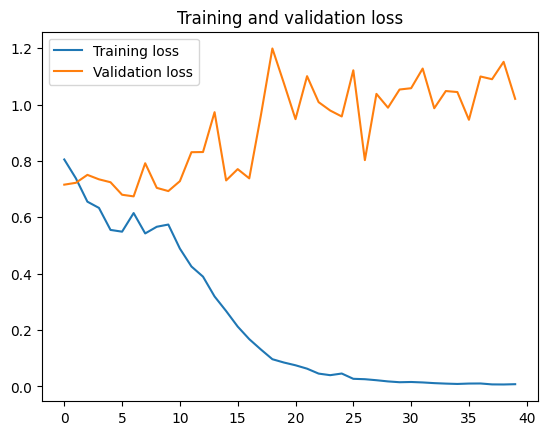

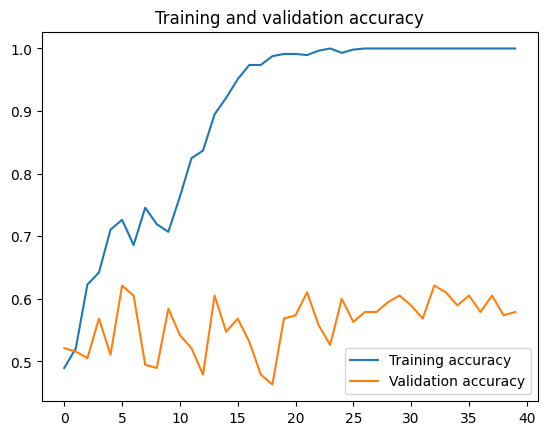

In [114]:
plt.figure()
plt.plot(epochs, train_loss[0:40], label='Training loss')
plt.plot(epochs, val_loss[0:40], label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, train_acc[0:40], label='Training accuracy')
plt.plot(epochs, val_acc[0:40], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [ ]:
print("START")
if not os.path.exists(OutputPathModels):
    os.makedirs(OutputPathModels)
print("Parameters loaded")
nSeizure=0

for indexPat in range(0, len(patients)):
    print('Patient '+patients[indexPat])
    loadSpectogramData(indexPat) 
       
    result='Out Seizure, True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR \n'
    filesPath = getFilesPathWithoutSeizure(indexPat)
    print(np.shape(filesPath))
        
initial_learning_rate = 0.001
decay_steps = 1000  # Numero di passi di addestramento dopo i quali applicare il decay
decay_rate = 0.1  # Tasso di decay
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

model = createModel()
model.summary()

history = model.fit(generate_arrays_for_training(filesPath, end=75), #end=75),#It take the first 75%
                        validation_data=generate_arrays_for_training(filesPath, start=75),#start=75), #It take the last 25%
                        #steps_per_epoch=10000, epochs=10)
                        steps_per_epoch=int((len(filesPath)-int(len(filesPath)/100*25))),#*25), 
                        validation_steps=int((len(filesPath)-int(len(filesPath)/100*75))),#*75),
                        epochs=60, max_queue_size=2, shuffle=True, callbacks=[LearningRateScheduler(lr_schedule)])# 100 epochs è meglio #aggiungere criterio di stop in base accuratezza

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Creates a HDF5 file 
model.save(OutputPathModels+"ModelPat"+patients[indexPat]+"/"+'ModelOutSeizure'+str(i+1)+'.h5')
print("Model saved")
        
epochs = range(len(train_loss))

plt.figure()
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

print('Training end')


In [7]:
model = load_model('altro/ModelPat.h5')

In [115]:
for indexPat in range(0, len(patients)):
    
    result='Patient '+patients[indexPat]+'\n'     
    result='Out Seizure, True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR \n'
    print('Patient '+patients[indexPat])
    loadSpectogramData(indexPat) 
    
    for i in range(0, nSeizure):
        
        print('Testing start')
        filesPath=interictalSpectograms[i]
        interPrediction=model.predict(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath))
        filesPath=preictalRealSpectograms[i]
        preictPrediction=model.predict(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath))
        print('Testing end')
        
        if not os.path.exists(OutputPathModels+"OutputTest"+"/"):
            os.makedirs(OutputPathModels+"OutputTest"+"/")
        np.savetxt(OutputPathModels+"OutputTest"+"/"+"Int_"+patients[indexPat]+"_"+str(i+1)+".csv", interPrediction, delimiter=",")
        np.savetxt(OutputPathModels+"OutputTest"+"/"+"Pre_"+patients[indexPat]+"_"+str(i+1)+".csv", preictPrediction, delimiter=",")
        
        secondsInterictalInTest=len(interictalSpectograms[i])*50*30#50 spectograms for file, 30 seconds for each spectogram
        acc=0#accumulator
        fp=0
        tp=0
        fn=0
        lastTenResult=list()
        
        for el in interPrediction:
            if(el[1]>0.5):
                acc=acc+1
                lastTenResult.append(1)
            else:
                lastTenResult.append(0)
            if(len(lastTenResult)>10):
                acc=acc-lastTenResult.pop(0)
            if(acc>=3):
                fp=fp+1
                lastTenResult=list()
                acc=0
        
        lastTenResult=list()
        for el in preictPrediction:
            if(el[1]>0.5):
                acc=acc+1
                lastTenResult.append(1)
            else:
                lastTenResult.append(0)
            if(len(lastTenResult)>10):
                acc=acc-lastTenResult.pop(0)
            if(acc>=3):
                tp=tp+1 
            else:
                if(len(lastTenResult)==10):
                    fn=fn+1 
                    
        if (tp+fn) != 0:
            sensitivity=tp/(tp+fn)
        else:
            sensitivity=0
        
        FPR=fp/(secondsInterictalInTest/(60*60))
        
        result=result+str(i+1)+','+str(tp)+','+str(fp)+','+str(fn)+','+str(secondsInterictalInTest)+','
        result=result+str(sensitivity)+','+str(FPR)+'\n'
        print('True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR')
        print(str(tp)+','+str(fp)+','+str(fn)+','+str(secondsInterictalInTest)+','+str(sensitivity)+','+str(FPR))
    with open(OutputPath, "a+") as myfile:
        myfile.write(result)

    if not os.path.exists(OutputPathModels+"OutputTest"+"/"):
        os.makedirs(OutputPathModels+"OutputTest"+"/")
    np.savetxt(OutputPathModels+"OutputTest"+"/"+"Int_"+patients[indexPat]+"_"+str(i+1)+".csv", interPrediction, delimiter=",")
    np.savetxt(OutputPathModels+"OutputTest"+"/"+"Pre_"+patients[indexPat]+"_"+str(i+1)+".csv", preictPrediction, delimiter=",")
            

with open(OutputPath, "a+") as myfile:
    myfile.write(result)

Patient 01
Testing start
12/12 [==============================] - 1s 101ms/step
Testing end
True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR
11,1,0,142500,1.0,0.02526315789473684
Testing start
12/12 [==============================] - 1s 89ms/step
Testing end
True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR
11,2,0,142500,1.0,0.05052631578947368
Testing start
12/12 [==============================] - 1s 86ms/step
Testing end
True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR
11,2,0,141000,1.0,0.05106382978723405
Testing start
10/10 [==============================] - 1s 100ms/step
Testing end
True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR
9,4,0,106500,1.0,0.13521126760563382
Testing start
8/8 [==============================] - 1s 77ms/step
Testing end
True Positive, False Positive, False negative, Second of Inter in Test, Sensitivit

ResourceExhaustedError: Graph execution error:

MemoryError: Unable to allocate 56.4 MiB for an array with shape (1, 50, 22, 59, 114) and data type float64
Traceback (most recent call last):

  File "C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\ops\script_ops.py", line 267, in __call__
    ret = func(*args)

  File "C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\data_adapter.py", line 902, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24172\1835626746.py", line 13, in generate_arrays_for_predict
    x=np.array([x])

numpy.core._exceptions._ArrayMemoryError: Unable to allocate 56.4 MiB for an array with shape (1, 50, 22, 59, 114) and data type float64


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_616458]

In [8]:
for indexPat in range(0, len(patients)):
    
    result='Patient '+patients[indexPat]+'\n'     
    result='Out Seizure, True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR \n'
    print('Patient '+patients[indexPat])
    loadSpectogramData(indexPat) 
    
    for i in range(0, nSeizure):
        
        print('Testing start')
        filesPath=interictalSpectograms[i]
        interPrediction=model.predict(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath))
        filesPath=preictalRealSpectograms[i]
        preictPrediction=model.predict(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath))
        print('Testing end')

        if not os.path.exists(OutputPathModels+"OutputTest"+"/"):
            os.makedirs(OutputPathModels+"OutputTest"+"/")
        np.savetxt(OutputPathModels+"OutputTest"+"/"+"Int_"+patients[indexPat]+"_"+str(i+1)+".csv", interPrediction, delimiter=",")
        np.savetxt(OutputPathModels+"OutputTest"+"/"+"Pre_"+patients[indexPat]+"_"+str(i+1)+".csv", preictPrediction, delimiter=",")
        
        secondsInterictalInTest=len(interictalSpectograms[i])*50*30#50 spectograms for file, 30 seconds for each spectogram
        acc=0#accumulator
        fp=0
        tp=0
        fn=0
        tn=0
        
        for el in interPrediction:
            if(el[1]>0.5):
                fp=fp+1
            else:
                tn=tn+1

        for el in preictPrediction:
            if(el[1]>0.5):
                tp=tp+1
            else:
                fn=fn+1
                    
        if (tp+fn) != 0:
            sensitivity=tp/(tp+fn)
        else:
            sensitivity=0
        
        FPR=fp/(secondsInterictalInTest/(60*60))
        
        result=result+str(i+1)+','+str(tp)+','+str(fp)+','+str(fn)+','+str(secondsInterictalInTest)+','
        result=result+str(sensitivity)+','+str(FPR)+'\n'
        print('True Positive, False Positive, False negative, True Negative, Second of Inter in Test, Sensitivity, FPR')
        print(str(tp)+','+str(fp)+','+str(fn)+','+str(tn)+','+str(secondsInterictalInTest)+','+str(sensitivity)+','+str(FPR))
    with open(OutputPath, "a+") as myfile:
        myfile.write(result)

    if not os.path.exists(OutputPathModels+"OutputTest"+"/"):
        os.makedirs(OutputPathModels+"OutputTest"+"/")
    np.savetxt(OutputPathModels+"OutputTest"+"/"+"Int_"+patients[indexPat]+"_"+str(i+1)+".csv", interPrediction, delimiter=",")
    np.savetxt(OutputPathModels+"OutputTest"+"/"+"Pre_"+patients[indexPat]+"_"+str(i+1)+".csv", preictPrediction, delimiter=",")
            

with open(OutputPath, "a+") as myfile:
    myfile.write(result)

Patient 01
Testing start
2/2 [==============================] - 0s 20ms/step
Testing end
True Positive, False Positive, False negative, True Negative, Second of Inter in Test, Sensitivity, FPR
2,0,0,5,7500,1.0,0.0
Testing start
2/2 [==============================] - 0s 21ms/step
Testing end
True Positive, False Positive, False negative, True Negative, Second of Inter in Test, Sensitivity, FPR
1,1,1,4,7500,0.5,0.48
Testing start
2/2 [==============================] - 0s 26ms/step
Testing end
True Positive, False Positive, False negative, True Negative, Second of Inter in Test, Sensitivity, FPR
1,0,1,5,7500,0.5,0.0
Testing start
2/2 [==============================] - 0s 60ms/step
Testing end
True Positive, False Positive, False negative, True Negative, Second of Inter in Test, Sensitivity, FPR
2,0,0,5,7500,1.0,0.0
Testing start
2/2 [==============================] - 0s 22ms/step
Testing end
True Positive, False Positive, False negative, True Negative, Second of Inter in Test, Sensitivity